#**CASTING DEFECT PREDICTION (IMAGE CLASSIFIER)**

#### **Aim :**
Our Aim is to predict whether the Given Image is casted Correctly or Not 

**Purpose :**

Following are the Advantages
* Reduction in Quality Control Cost
* Accuracy is More
* Ability to Meet the Demands Quickly
* Time Saving Process

####**Steps :**
* Collecting the Data (Our Source from Kaggle)
  Other Sources Like 
       1. Companies Official DataBase API
       2. Cloud Sources Like Microsoft Azure (Event Hub, IOT Workspace) 
* Data Preprocessing and Augumentation
* Model Selection Using Keras Tuner
* Model Building
* Deployment Phase
        1. Since its an Edge analytics project I Have been Tried to use TFLite Model for low power Availability and Processing the Model Deployment.
        2. Steps : loading tflite model into IOT Devices using Various cloud Providers Like (Microsoft Edge Analytics Platform, Google Edge Analytics and AWS IOT GreenGrass)
        3. But due to lack of availability of Resources here i going to deploy the model into a web app.  

**1.0 Collecting the Data (Kaggle Datasets)**

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sukilsiva","key":"b53bd3cbf685e7c10b14766f3b974bb0"}'}

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!ls ~/.kaggle

kaggle.json


In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product

 89% 89.0M/100M [00:04<00:00, 16.3MB/s]
100% 100M/100M [00:04<00:00, 24.0MB/s] 


In [8]:
!unzip /content/real-life-industrial-dataset-of-casting-product.zip

Streaming output truncated to the last 5000 lines.
  inflating: casting_data/casting_data/train/def_front/cast_def_0_526.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5260.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5262.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5265.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_527.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5270.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5272.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5274.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_528.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5282.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5283.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5284.jpeg  
  inflating: cas

 **2.0 Data Preprocessing**

In [9]:
### Imoprting the Libraries

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input, Lambda
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import matplotlib.pyplot as plt
import numpy as np

print(tf.__version__)

2.3.0


In [10]:
### Specifying the Size of the Images
img_width = 128
img_height = 128

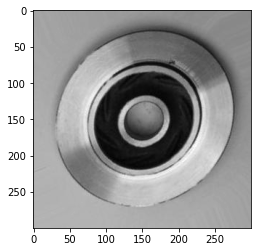

In [11]:
### Lets have a Look into the data
import cv2
from tqdm import tqdm
import os

DATADIR = "/content/casting_data/casting_data/train"

CATEGORIES = ["def_front", "ok_front"]

for category in CATEGORIES:  # do Defect and Ok Product
    path = os.path.join(DATADIR,category)  # create path to defect and ok products
    for img in os.listdir(path):  # iterate over each image per defect and ok
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

In [12]:
### Look at the array
print(img_array)

[[163 163 163 ... 137 137 137]
 [163 163 163 ... 137 137 137]
 [163 163 163 ... 137 137 137]
 ...
 [176 176 177 ... 163 162 161]
 [176 177 177 ... 163 162 161]
 [177 177 177 ... 163 162 161]]


In [13]:
print(img_array.shape)

(300, 300)


 So that's a 300 tall, 300 wide, and 3-channel image. 3-channel is because it's RGB (color). We definitely don't want the images that big, but also various images are different shapes, and this is also a problem.

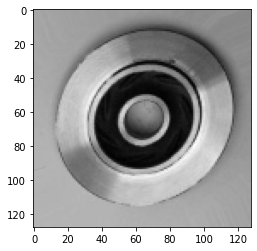

In [14]:
new_array = cv2.resize(img_array, (img_width, img_height))
plt.imshow(new_array, cmap='gray')
plt.show()

In [15]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do defect and ok

        path = os.path.join(DATADIR,category)  # create path to defect and ok
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=defect 1=ook

        for img in tqdm(os.listdir(path)):  # iterate over each image per defect and ok
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (img_width, img_height))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

100%|██████████| 2875/2875 [00:01<00:00, 1543.35it/s]


In [16]:
import random

random.shuffle(training_data)

In [17]:
X_train = []
y_train = []

for features,label in training_data:
    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train).reshape(-1, img_width, img_height, 1)

In [18]:
### Converting the Images between 0 and 1
X_train = X_train/255.0

In [19]:
X_train = np.array(X_train)
X_train

array([[[[0.62352941],
         [0.62352941],
         [0.6       ],
         ...,
         [0.67843137],
         [0.6745098 ],
         [0.6745098 ]],

        [[0.62745098],
         [0.62352941],
         [0.60392157],
         ...,
         [0.65882353],
         [0.67058824],
         [0.67058824]],

        [[0.62745098],
         [0.62745098],
         [0.60784314],
         ...,
         [0.69019608],
         [0.69803922],
         [0.69803922]],

        ...,

        [[0.67058824],
         [0.67058824],
         [0.67058824],
         ...,
         [0.75294118],
         [0.75294118],
         [0.74509804]],

        [[0.67058824],
         [0.66666667],
         [0.6627451 ],
         ...,
         [0.74901961],
         [0.75294118],
         [0.74117647]],

        [[0.67058824],
         [0.66666667],
         [0.66666667],
         ...,
         [0.74901961],
         [0.75294118],
         [0.74117647]]],


       [[[0.85882353],
         [0.85882353],
         [0.85

In [20]:
X_train[0].shape

(128, 128, 1)

In [21]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_train

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [22]:
y_train.shape

(6633, 1)

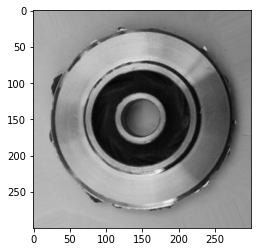

In [23]:
DATADIR = "/content/casting_data/casting_data/test"

CATEGORIES = ["def_front", "ok_front"]

for category in CATEGORIES:  # do Defect and Ok Product
    path = os.path.join(DATADIR,category)  # create path to defect and ok products
    for img in os.listdir(path):  # iterate over each image per defect and ok
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

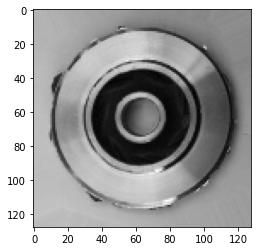

In [24]:
new_array = cv2.resize(img_array, (img_width, img_height))
plt.imshow(new_array, cmap='gray')
plt.show()

In [25]:
testing_data = []

def create_testing_data():
    for category in CATEGORIES:  # do defect and ok

        path = os.path.join(DATADIR,category)  # create path to defect and ok
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=defect 1=ook

        for img in tqdm(os.listdir(path)):  # iterate over each image per defect and ok
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (img_width, img_height))  # resize to normalize data size
                testing_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_testing_data()

100%|██████████| 262/262 [00:00<00:00, 1540.26it/s]


In [26]:
import random

random.shuffle(testing_data)

In [27]:
X_test = []
y_test = []

for features,label in testing_data:
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test).reshape(-1, img_width, img_height, 1)

In [28]:
X_test = X_test/255.0
X_test[0].shape

(128, 128, 1)

In [29]:
X_test = np.array(X_test)
X_test

array([[[[0.6627451 ],
         [0.6627451 ],
         [0.6627451 ],
         ...,
         [0.8       ],
         [0.80392157],
         [0.80392157]],

        [[0.66666667],
         [0.66666667],
         [0.66666667],
         ...,
         [0.8       ],
         [0.80392157],
         [0.80392157]],

        [[0.67058824],
         [0.67058824],
         [0.67058824],
         ...,
         [0.8       ],
         [0.80392157],
         [0.80392157]],

        ...,

        [[0.74509804],
         [0.73333333],
         [0.7372549 ],
         ...,
         [0.88627451],
         [0.88627451],
         [0.88627451]],

        [[0.74509804],
         [0.72156863],
         [0.74901961],
         ...,
         [0.89411765],
         [0.89019608],
         [0.89019608]],

        [[0.74509804],
         [0.72156863],
         [0.75294118],
         ...,
         [0.89411765],
         [0.89019608],
         [0.89019608]]],


       [[[0.57254902],
         [0.57254902],
         [0.57

In [30]:
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
y_test

array([[1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],

In [31]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

6633 715 6633 715


In [32]:
print(type(X_train), type(X_test),type(y_train), type(y_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [33]:
X_train[0].shape

(128, 128, 1)

In [34]:
y_train[0].shape

(1,)

 **3.0 Model Selection Using Keras Tuner**

In [35]:
!pip install keras-tuner

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=d257ed2a4bf0d30e1eefc83e115a1bae27fb97eeee170a73b1e39a9367c38e7f
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=e99cb5a6955db05c2a304eaaeb4138d37829163cf4dfedaa88f80c5b72dae655
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [36]:
### importing the Keras Tuner Library
from kerastuner import RandomSearch

In [37]:
def build_model_1(hp):  
  model = Sequential([
                      ### Input Layer
                      Conv2D(
                             filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                             kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                             activation='relu',
                             input_shape=(img_width,img_height,1)
                            ),
                      MaxPool2D(
                             pool_size=hp.Choice("pooling_1_strides", values=[2,3])
                            ),
                      Dropout(
                          rate=hp.Choice("Dropout_layer_1", values=[0.2,0.3,0.4])
                            ),

                     ### Hidden Layer
                     Conv2D(
                            filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
                            kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                            activation='relu'
                            ),
                     MaxPool2D(
                          pool_size=hp.Choice("pooling_2_strides", values=[2,3])
                            ),
                     Dropout(
                          rate=hp.Choice("Dropout_layer_2", values=[0.2,0.3,0.4])
                            ),
                      
                     ### Hidden Layer 2
                     Conv2D(
                            filters=hp.Int("Conv_3_Filter", min_value=16, max_value=32, step=16),
                            kernel_size=hp.Choice("Conv_2_Kernel", values=[3,5]),
                            activation="relu"
                           ),
                      MaxPool2D(
                          pool_size=hp.Choice("pooling_3_strides", values=[2,3])
                         ),
                      Dropout(
                          rate=hp.Choice("Dropout_layer_3", values=[0.2,0.3,0.4])
                          ),

                    ### Output Layer
                    Flatten(),
                    Dense(
                          units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
                          activation='relu'
                          ),
                    Dense(2, activation='sigmoid')
  ])
  
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [38]:
### HyperParametre Tuning
tuner_search=RandomSearch(build_model_1,
                          objective='val_accuracy',
                          max_trials=5,directory='output_1',project_name="Casting_Defects")

In [39]:
tuner_search.search(X_train,y_train,epochs=10,validation_data=(X_test, y_test))

Epoch 1/10
208/208 [==============================] - 13s 63ms/step - loss: 0.6996 - accuracy: 0.5626 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 2/10
208/208 [==============================] - 13s 60ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 3/10
208/208 [==============================] - 12s 60ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 4/10
208/208 [==============================] - 13s 61ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 5/10
208/208 [==============================] - 13s 60ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 6/10
208/208 [==============================] - 13s 61ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 7/10
208/208 [==============================] - 13s 61ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy:

Epoch 1/10
208/208 [==============================] - 11s 53ms/step - loss: 0.6885 - accuracy: 0.5583 - val_loss: 0.6882 - val_accuracy: 0.6336
Epoch 2/10
208/208 [==============================] - 10s 50ms/step - loss: 0.6808 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 3/10
208/208 [==============================] - 10s 50ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 4/10
208/208 [==============================] - 10s 50ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 5/10
208/208 [==============================] - 10s 50ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 6/10
208/208 [==============================] - 10s 50ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 7/10
208/208 [==============================] - 10s 50ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy:

Epoch 1/10
208/208 [==============================] - 13s 63ms/step - loss: 0.7004 - accuracy: 0.5638 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 2/10
208/208 [==============================] - 13s 61ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 3/10
208/208 [==============================] - 13s 61ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 4/10
208/208 [==============================] - 13s 61ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 5/10
208/208 [==============================] - 13s 61ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 6/10
208/208 [==============================] - 13s 61ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy: 0.6336
Epoch 7/10
208/208 [==============================] - 13s 61ms/step - loss: 0.6931 - accuracy: 0.5666 - val_loss: 0.6931 - val_accuracy:

Epoch 1/10
208/208 [==============================] - 11s 51ms/step - loss: 0.6937 - accuracy: 0.5663 - val_loss: 0.6680 - val_accuracy: 0.6336
Epoch 2/10
208/208 [==============================] - 10s 50ms/step - loss: 0.6844 - accuracy: 0.5666 - val_loss: 0.6724 - val_accuracy: 0.6336
Epoch 3/10
208/208 [==============================] - 10s 50ms/step - loss: 0.6848 - accuracy: 0.5666 - val_loss: 0.6626 - val_accuracy: 0.6336
Epoch 4/10
208/208 [==============================] - 10s 49ms/step - loss: 0.6848 - accuracy: 0.5666 - val_loss: 0.6637 - val_accuracy: 0.6336
Epoch 5/10
208/208 [==============================] - 10s 50ms/step - loss: 0.6846 - accuracy: 0.5666 - val_loss: 0.6677 - val_accuracy: 0.6336
Epoch 6/10
208/208 [==============================] - 10s 49ms/step - loss: 0.6847 - accuracy: 0.5666 - val_loss: 0.6626 - val_accuracy: 0.6336
Epoch 7/10
208/208 [==============================] - 10s 49ms/step - loss: 0.6847 - accuracy: 0.5666 - val_loss: 0.6670 - val_accuracy:

Epoch 1/10
208/208 [==============================] - 9s 42ms/step - loss: 0.6329 - accuracy: 0.5629 - val_loss: 0.4961 - val_accuracy: 0.6336
Epoch 2/10
208/208 [==============================] - 8s 41ms/step - loss: 0.4778 - accuracy: 0.5669 - val_loss: 0.4089 - val_accuracy: 0.6364
Epoch 3/10
208/208 [==============================] - 8s 40ms/step - loss: 0.4271 - accuracy: 0.5666 - val_loss: 0.5616 - val_accuracy: 0.6364
Epoch 4/10
208/208 [==============================] - 8s 40ms/step - loss: 0.4131 - accuracy: 0.5687 - val_loss: 0.3688 - val_accuracy: 0.6364
Epoch 5/10
208/208 [==============================] - 8s 41ms/step - loss: 0.4028 - accuracy: 0.5729 - val_loss: 0.3397 - val_accuracy: 0.6671
Epoch 6/10
208/208 [==============================] - 8s 40ms/step - loss: 0.3609 - accuracy: 0.7113 - val_loss: 0.3580 - val_accuracy: 0.7958
Epoch 7/10
208/208 [==============================] - 8s 40ms/step - loss: 0.2205 - accuracy: 0.9020 - val_loss: 0.1504 - val_accuracy: 0.9203

INFO:tensorflow:Oracle triggered exit


In [40]:
model=tuner_search.get_best_models(num_models=1)[0]

In [41]:
model.add(tf.keras.Input(shape=(img_width,img_height,1)))

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 48)      1248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 48)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 48)        20784     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        1

 **4.0 Model Building**

Lets Check the Model How its performing with new Data

In [43]:
model.fit(X_train, y_train, epochs=10 ,validation_split= 0.2)

Epoch 1/10
166/166 [==============================] - 8s 46ms/step - loss: 0.1274 - accuracy: 0.9252 - val_loss: 0.0931 - val_accuracy: 0.9397
Epoch 2/10
166/166 [==============================] - 7s 42ms/step - loss: 0.1077 - accuracy: 0.9331 - val_loss: 0.1122 - val_accuracy: 0.9314
Epoch 3/10
166/166 [==============================] - 7s 42ms/step - loss: 0.0982 - accuracy: 0.9333 - val_loss: 0.1103 - val_accuracy: 0.9329
Epoch 4/10
166/166 [==============================] - 7s 43ms/step - loss: 0.0893 - accuracy: 0.9374 - val_loss: 0.1452 - val_accuracy: 0.9284
Epoch 5/10
166/166 [==============================] - 7s 42ms/step - loss: 0.0953 - accuracy: 0.9325 - val_loss: 0.0663 - val_accuracy: 0.9397
Epoch 6/10
166/166 [==============================] - 7s 42ms/step - loss: 0.0838 - accuracy: 0.9423 - val_loss: 0.0696 - val_accuracy: 0.9390
Epoch 7/10
166/166 [==============================] - 7s 42ms/step - loss: 0.0834 - accuracy: 0.9403 - val_loss: 0.0673 - val_accuracy: 0.9465

In [52]:
def predictions(image):
  ### Loading the Image
  test_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
  plt.imshow(test_image, cmap="gray") # Plot Image
  test_image= np.array(test_image).reshape(-1, img_width, img_height, 1)
  test_image = test_image/255.0
  test_image = np.array(test_image)

  ###Predictions
  results = model.predict(test_image)
  if results[0][0] >= 0.5:
    predictions = 'OK Product'
  else:
    predictions = 'Defect Product'

  return ("Predictions :",predictions)

Enter the Image To be Predicted:/content/casting_512x512/casting_512x512/ok_front/cast_ok_0_1018.jpeg


('Predictions :', 'OK Product')

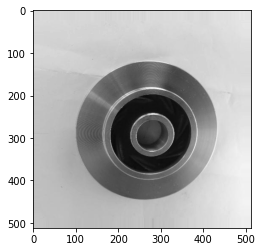

In [57]:
img = input("Enter the Image To be Predicted:")
predictions(img)

OK to identify the correct one

Enter the Image To be Predicted:/content/casting_512x512/casting_512x512/def_front/cast_def_0_0.jpeg


('Predictions :', 'Defect Product')

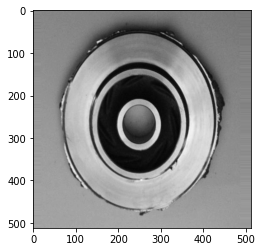

In [58]:
img = input("Enter the Image To be Predicted:")
predictions(img)

!!! Works fine to identify Defects Too